# calc w'b' ~ Ri with scaling

parameterization of Killworth
$$\frac{\overline{w'b'}}{H^2f^3} = C_s \frac{1}{\sqrt{1+Ri}} \mu_s(z) \alpha^2$$

$$\mu_s(z) = -4 \frac{z}{H} (\frac{z}{H} + 1)$$

H is mixed layer depth
C_s is 1


In [14]:
%%capture
import sys
import glob, os
os.chdir('/home/m/m300878/submesoscaletelescope/notebooks/may22/')
sys.path.insert(1, '../')
from icon_smt_levels import dzw, dzt, depthc, depthi
sys.path.insert(1, '/home/m/m300878/submesoscaletelescope/run_batch_job/model_evaluation/')
#from eval_funcs import *
import eval_funcs as eva

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import pyicon as pyic
import gsw

from scipy import stats    #Used for 2D binned statistics

### select region

In [246]:
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.nc'

lon_reg_large = [-72.5, -55]
lat_reg_large = [32, 42]
asp_large = (lat_reg_large[1]-lat_reg_large[0])/(lon_reg_large[1]-lon_reg_large[0])

lon_reg = [-65, -60]
lat_reg = [38.75, 41.25]
lon_reg = [-65, -60]
lat_reg = [33, 35.5]
calcname = 'small_33_34'



lon_reg = lon_reg_large
lat_reg = lat_reg_large
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])

idepth = 5
itime = 42

##### funcs

In [247]:
def scatter_data(x,y):
    plt.figure()
    plt.scatter(x,y)
    #plt.xlim(-1, 10)
    #plt.ylim(-5,5)

In [248]:
def calc_log10(x_data, y_data):
    #x_data = np.reshape(rhs.data, laty*lonx)
    #y_data = np.reshape(lhs.data, laty*lonx)
    #x_data = np.reshape(ri_mld_mean.data, laty*lonx)

    #scatter_data(x_data,y_data)
    #y_data = np.reshape(wb_mld_mean.data, laty*lonx)
    mask = ~np.isnan(x_data) & ~np.isnan(y_data) #remove nans from original data
    x_data = x_data[mask]
    y_data = y_data[mask]
    #scatter_data(x_data,y_data) # nothing happens

    mask = np.ma.masked_where((x_data >= 0), x_data) # remove zeros and negative numbers from xdata
    x_data = x_data[mask.mask]
    y_data = y_data[mask.mask]
    #scatter_data(x_data,y_data)

    logx = np.log10(np.abs(x_data)) #not nessecary
    logy = np.log10(np.abs(y_data))
    #scatter_data(logx,logy)
    mask = ~np.isnan(logx) & ~np.isnan(logy) & ~np.isinf(logy) #remove inf numbers and nans again after taking log
    logx = logx[mask]
    logy = logy[mask]
    #x_data = x_data[mask]
    #y_data = y_data[mask]
    return(logx,logy)

## calc H - MLD

In [249]:
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/t.nc'
t_mean = xr.open_dataset(path_data, chunks=dict(depthc=1))
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/s.nc'
s_mean = xr.open_dataset(path_data, chunks=dict(depthc=1))

In [250]:
rho_mean = gsw.rho(s_mean.S001_sp, t_mean.T001_sp, depthc[2])
rho_mean

<xarray.DataArray 'S001_sp' (depthc: 112, ncells: 59799625)>
dask.array<rho, shape=(112, 59799625), dtype=float64, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Attributes:
    time averaged:  2010-03-15T21 - 2010-03-22T21
    time steps:     85

In [251]:
data_rho_mean      = pyic.interp_to_rectgrid_xr(rho_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

#### mld + mask

In [252]:
def calc_mld_montegut(rho_mean, depthc):
    """ 
    applies Montegut 2004 Threshold Method
    if salinity can be negelcted it is equivalent to dT = 0.2 
    """

    rho_surf_mean = rho_mean.isel(depthc=2) #should be 10m
    diff = np.sqrt((rho_surf_mean - rho_mean)**2)
    
    d = diff.where(diff<=0.03)
    dd = np.sum(~np.isnan(d), axis=2)
    
    return(depthc[dd-1], ~np.isnan(d))   

In [253]:
%%time
mld, mld_mask = calc_mld_montegut(data_rho_mean, depthc)

CPU times: user 305 ms, sys: 212 ms, total: 517 ms
Wall time: 517 ms


In [336]:
mld.shape

(500, 875)

In [339]:
mldx =  xr.DataArray(data=mld, dims=["lat", "lon"], coords=dict(lon=(["lon"], mld_mask.lon.data), lat=(["lat"], mld_mask.lat.data)))
mldx

<xarray.DataArray (lat: 500, lon: 875)>
array([[  30.5 ,   27.5 ,   27.5 , ...,   36.5 ,   36.5 ,   36.5 ],
       [  27.5 ,   30.5 ,   30.5 , ...,   36.5 ,   36.5 ,   36.5 ],
       [  30.5 ,   30.5 ,   30.5 , ...,   33.5 ,   36.5 ,   36.5 ],
       ...,
       [5489.75, 5489.75, 5489.75, ...,  197.5 ,  197.5 ,  192.5 ],
       [5489.75, 5489.75, 5489.75, ...,  192.5 ,  192.5 ,  187.75],
       [5489.75, 5489.75, 5489.75, ...,  192.5 ,  187.75,  183.25]])
Coordinates:
  * lon      (lon) float64 -72.5 -72.48 -72.46 -72.44 ... -55.06 -55.04 -55.02
  * lat      (lat) float64 32.02 32.04 32.06 32.08 ... 41.94 41.96 41.98 42.0

## calc f

In [254]:
lat = data_rho_mean.lat
f = f=2*2*np.pi/86400*np.sin(lat*np.pi/180.)

## calc Ri

In [255]:
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/dbdx.nc'
dbdx_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/dbdy.nc'
dbdy_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/n2.nc'
n_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))

In [256]:
data_dbdx_mean   = pyic.interp_to_rectgrid_xr(dbdx_mean.dbdx, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_dbdy_mean   = pyic.interp_to_rectgrid_xr(dbdy_mean.dbdy, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_n2_mean     = pyic.interp_to_rectgrid_xr(n_mean.N2, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

In [257]:
data_M2_mean = np.sqrt(np.power(data_dbdx_mean,2) + np.power(data_dbdy_mean,2))

In [258]:
lat_mean = int(data_n2_mean.lat[-1] - data_n2_mean.lat[0] )/2

In [259]:
ri_mean = eva.calc_richardsonnumber(lat_mean, data_n2_mean, data_M2_mean)

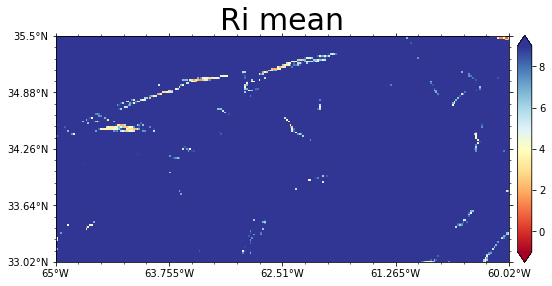

In [83]:
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=2, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= -1,9
#clim= 0, 1e-5
#pyic.shade(ri_mean.lon, ri_mean.lat, data_ri_b_mean.isel(depthi=5), ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False,  clim=clim,  cmap='RdYlBu')
pyic.shade(ri_mean.lon, ri_mean.lat, ri_mean.isel(depthi=5), ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False,  clim=clim,  cmap='RdYlBu')

ax.set_title('Ri mean', fontsize=30)

for ax in hca:
    pyic.plot_settings(ax)

### average over MLD

In [260]:
mld_mask = mld_mask.transpose('depthc', 'lat', 'lon')

In [261]:
ri_mean_select = ri_mean[:112]

In [262]:
ri_mld = ri_mean_select * mld_mask.data
ri_mld = ri_mld.where(ri_mld != 0)
ri_mld_mean = ri_mld.mean(dim='depthi', skipna=True)
ri_mld_mean

<xarray.DataArray (lat: 500, lon: 875)>
array([[1.8894176e+00, 1.3557039e+00, 1.5280954e+00, ..., 4.1995525e+01,
        1.6733059e+01, 9.4251890e+00],
       [7.9475009e-01, 1.2366272e+00, 1.1146652e+00, ..., 4.2976633e+02,
        5.8011036e+01, 9.1670399e+00],
       [3.3029842e+01, 2.7429202e+00, 7.6081562e+00, ..., 2.7605109e+02,
        8.8018394e+01, 2.8505346e+01],
       ...,
       [          nan,           nan,           nan, ..., 1.3288223e+01,
        4.0532465e+00, 1.7399521e+00],
       [          nan,           nan,           nan, ..., 4.9303198e+00,
        2.9007375e+00, 3.6939052e-01],
       [          nan,           nan,           nan, ..., 9.9971598e-01,
        6.4700117e+00, 1.6311690e+00]], dtype=float32)
Coordinates:
  * lat      (lat) float64 32.02 32.04 32.06 32.08 ... 41.94 41.96 41.98 42.0
  * lon      (lon) float64 -72.5 -72.48 -72.46 -72.44 ... -55.06 -55.04 -55.02

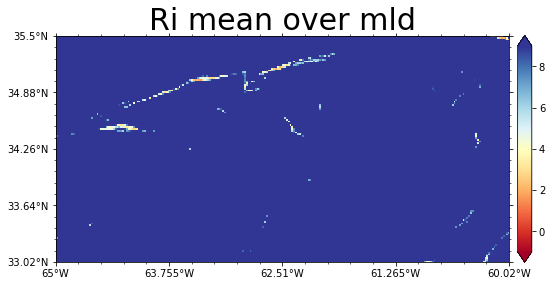

In [87]:
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=2, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= -1,9
#clim= 0, 1e-5
pyic.shade(ri_mean.lon, ri_mean.lat, ri_mld_mean, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False,  clim=clim,  cmap='RdYlBu')
ax.set_title('Ri mean over mld', fontsize=30)

for ax in hca:
    pyic.plot_settings(ax)

## get wb prime

In [263]:
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/wb_prime.nc'
wb_prime_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
wb_prime_mean = wb_prime_mean.rename(__xarray_dataarray_variable__='wb_prime_mean')

In [264]:
data_wb_prime_mean  = pyic.interp_to_rectgrid_xr(wb_prime_mean.wb_prime_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

(200.0, 0.0)

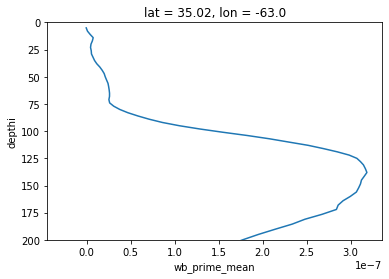

In [90]:
data_wb_prime_mean.isel(lat=100,lon=100).plot(y='depthi')
plt.ylim(200,0)

In [265]:
wb_mld = data_wb_prime_mean[:112] * mld_mask.data
wb_mld = wb_mld.where(wb_mld != 0) #neglect zeros in average
wb_mld_mean = wb_mld.mean(dim='depthi', skipna=True)
wb_mld_mean

<xarray.DataArray 'wb_prime_mean' (lat: 500, lon: 875)>
array([[ 7.3115316e-08,  6.0083352e-08,  7.0820263e-08, ...,
        -1.2736272e-08,  8.5873548e-09,  2.9185339e-08],
       [ 5.3585186e-08,  4.6121119e-08,  4.9475929e-08, ...,
        -5.4371299e-09,  1.4086719e-08,  2.4334581e-08],
       [ 4.8190518e-08,  4.4210978e-08,  3.5901799e-08, ...,
        -9.6021524e-10,  1.0507566e-08,  1.5807545e-08],
       ...,
       [           nan,            nan,            nan, ...,
         2.9728469e-08, -5.4280251e-09,  7.7533793e-09],
       [           nan,            nan,            nan, ...,
         1.4826927e-08,  1.4389532e-08,  1.7731351e-08],
       [           nan,            nan,            nan, ...,
         2.4078489e-08,  2.7164377e-08,  3.7347206e-08]], dtype=float32)
Coordinates:
  * lat      (lat) float64 32.02 32.04 32.06 32.08 ... 41.94 41.96 41.98 42.0
  * lon      (lon) float64 -72.5 -72.48 -72.46 -72.44 ... -55.06 -55.04 -55.02

In [266]:
M2_mld = data_M2_mean[:112] * mld_mask.data
M2_mld = M2_mld.where(M2_mld !=0)
M2_mld_mean = M2_mld.mean(dim='depthi', skipna=True)
M2_mld_mean

<xarray.DataArray (lat: 500, lon: 875)>
array([[2.87865554e-08, 3.30862235e-08, 3.18963345e-08, ...,
        1.00044559e-08, 1.30773801e-08, 1.34256588e-08],
       [4.40965522e-08, 3.63488013e-08, 4.30912976e-08, ...,
        8.16893841e-09, 1.32312303e-08, 1.32589042e-08],
       [1.76371540e-08, 2.72251679e-08, 2.00522443e-08, ...,
        6.01248695e-09, 1.07351461e-08, 9.41243705e-09],
       ...,
       [5.26159602e-05, 5.26159602e-05, 5.26159602e-05, ...,
        1.25047039e-08, 9.64792157e-09, 1.28107445e-08],
       [5.26159602e-05, 5.26159602e-05, 5.26159602e-05, ...,
        7.29274019e-09, 1.42999061e-08, 2.38387834e-08],
       [5.26159602e-05, 5.26159602e-05, 5.26159602e-05, ...,
        1.78674586e-08, 2.60932396e-08, 1.75130896e-08]], dtype=float32)
Coordinates:
  * lat      (lat) float64 32.02 32.04 32.06 32.08 ... 41.94 41.96 41.98 42.0
  * lon      (lon) float64 -72.5 -72.48 -72.46 -72.44 ... -55.06 -55.04 -55.02

### unscaled

In [93]:
laty, lonx, = ri_mld_mean.shape

In [94]:
logx, logy = calc_log10(np.reshape(ri_mld_mean.data, laty*lonx), np.reshape(wb_mld_mean.data, laty*lonx))

LinregressResult(slope=-0.1389350533878201, intercept=-7.3942377106143296, rvalue=-0.2120223016247783, pvalue=0.0, stderr=0.003622692259846441, intercept_stderr=0.009459011248528496)

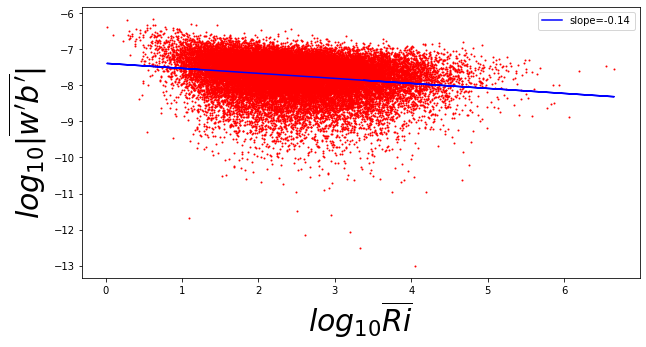

In [95]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=1)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')


#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{Ri}$', fontsize=30)
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}| $', fontsize=30)
res
plt.legend()

plt.savefig(f'../images/eval_ri/wb_ri_vert_mean_{calcname}.png', dpi=150, format='png', bbox_inches='tight')

res

## scaling

#### calcute alpha using mld averaged M2

In [96]:
#L =  # horizontal length scale
#H = mld #vertical length scale
#z = depthi
#delta = H / L 
#Ro = U / f / L
#alpha = Ro / delta
#mu = -4 * z / H * (z/H + 1)

alpha = M2_mld_mean / np.power(f,2)

#### calculate lhs and rhs (killworth), like Nils

In [97]:
lhs = wb_mld_mean / np.power(mld,2) / np.power(f,3) / np.power(alpha,2)
lhs_without_alpha = wb_mld_mean / np.power(mld,2) / np.power(f,3)
rhs = 1 / np.sqrt(1 + ri_mld_mean) #* np.power(alpha,2) #* mu * np.power(alpha,2)

In [98]:
lhs.mean()

<xarray.DataArray ()>
array(3.24519394)

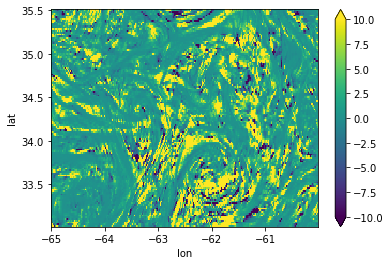

In [99]:
#with alpha
lhs.plot(vmin=-10, vmax=10)

In [100]:
mld.mean()

66.520664

In [101]:
logx, logy = calc_log10(np.reshape(ri_mld_mean.data, laty*lonx), np.reshape(lhs_without_alpha.data, laty*lonx))

LinregressResult(slope=-0.23464861211910468, intercept=1.5202616683864576, rvalue=-0.29235834451481035, pvalue=0.0, stderr=0.004341997343558372, intercept_stderr=0.011337148940037322)

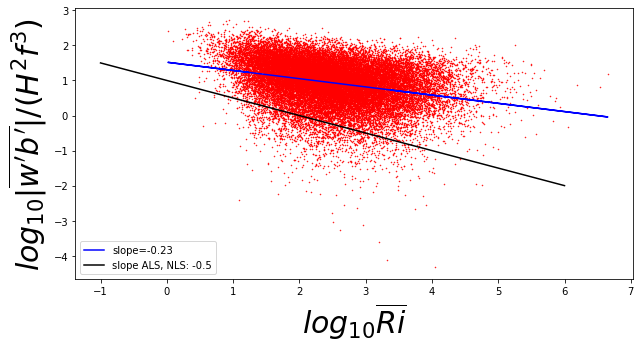

In [102]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=0.5)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

x1 = np.linspace(-1,6,100)
y1 = -0.5*x1 + 1
plt.plot(x1,y1, label='slope ALS, NLS: -0.5', color='black')
#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{Ri}$', fontsize=30)
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3) $', fontsize=30)
res
plt.legend()

plt.savefig(f'../images/eval_ri/wb_ri_vert_mean_scaled_{calcname}.png', dpi=150, format='png', bbox_inches='tight')

res

In [103]:
logx, logy = calc_log10(np.reshape(rhs.data, laty*lonx), np.reshape(lhs.data, laty*lonx))

LinregressResult(slope=-1.1153190734330463, intercept=-1.2523102989658101, rvalue=-0.6131222902171788, pvalue=0.0, stderr=0.008129454624046321, intercept_stderr=0.010625220104499285)

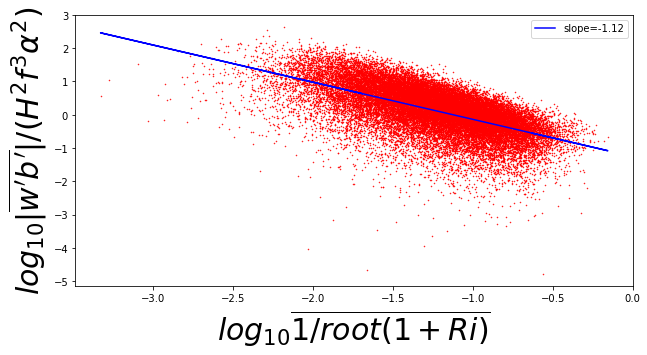

In [104]:

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=0.5)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

# x1 = np.linspace(-1,6,100)
# y1 = -0.5*x1 + 1
# plt.plot(x1,y1, label='slope ALS, NLS: -0.5', color='black')
#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{1 / root(1+Ri)} $', fontsize=30) #
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3 \alpha^2) $', fontsize=30)
res
plt.legend()

plt.savefig(f'../images/eval_ri/wb_ri_vert_mean_scaled_lhs_rhs_{calcname}.png', dpi=150, format='png', bbox_inches='tight')

res

In [105]:
logx, logy = calc_log10(np.reshape(ri_mld_mean.data, laty*lonx), np.reshape(lhs.data, laty*lonx))

LinregressResult(slope=0.5531077787776624, intercept=-1.2380847564471706, rvalue=0.6132007139724247, pvalue=0.0, stderr=0.004030723767020286, intercept_stderr=0.010524399732913596)

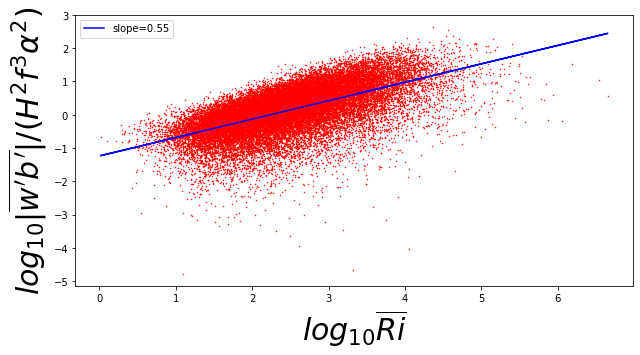

In [106]:

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=0.5)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

# x1 = np.linspace(-1,6,100)
# y1 = -0.5*x1 + 1
# plt.plot(x1,y1, label='slope ALS, NLS: -0.5', color='black')
#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{Ri}$', fontsize=30)
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3 \alpha^2) $', fontsize=30)

plt.legend()

plt.savefig(f'../images/eval_ri/wb_ri_vert_mean_scaled_alpha_{calcname}.png', dpi=150, format='png', bbox_inches='tight')

res

### a glance on alpha dependency

In [107]:
#x_data = np.reshape(rhs.data, laty*lonx)
y_data = np.reshape(lhs.data, laty*lonx)
x_data = np.reshape(alpha.data, laty*lonx)
#y_data = np.reshape(wb_mld_mean.data, laty*lonx)
mask = ~np.isnan(x_data) & ~np.isnan(y_data) #remove nans from original data
x_data = x_data[mask]
y_data = y_data[mask]

mask = np.ma.masked_where((x_data >= 0), x_data) # remove zeros and negative numbers from xdata
x_data = x_data[mask.mask]
y_data = y_data[mask.mask]

logx = np.log10(np.abs(x_data)) #not nessecary
logy = np.log10(np.abs(y_data))
mask = ~np.isnan(logx) & ~np.isnan(logy) & ~np.isinf(logy) #remove inf numbers and nans again after taking log
logx = logx[mask]
logy = logy[mask]
x_data = x_data[mask]
y_data = y_data[mask]

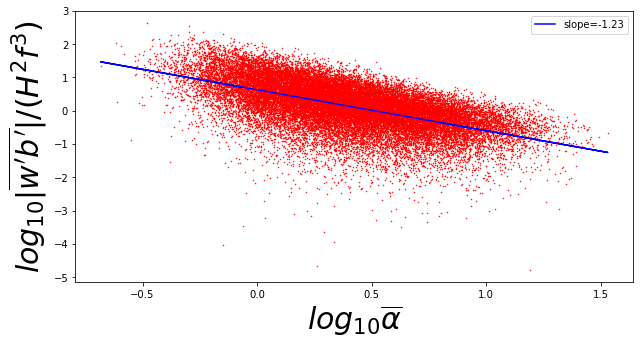

In [108]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=0.5)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

# x1 = np.linspace(-1,6,100)
# y1 = -0.5*x1 + 1
# plt.plot(x1,y1, label='slope ALS, NLS: -0.5', color='black')
#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{\alpha}$', fontsize=30)
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3) $', fontsize=30)
res
plt.legend()

# Evaluate one front vertical slice

In [8]:
def get_slice_data(data, fpath_ckdtree, lon_reg, lat_reg):
    out = pyic.interp_to_rectgrid_xr(data, fpath_ckdtree, lon_reg=lon_reg, lat_reg=(lat_reg[0],lat_reg[0]+0.02), compute=False)
    return  out

## slices

In [311]:
data_M2_mean

<xarray.DataArray (depthi: 113, lat: 500, lon: 875)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[1.9458284e-08, 2.5944038e-08, 2.9988954e-08, ...,
         3.3255199e-09, 8.0709333e-09, 1.4424312e-08],
        [3.7874663e-08, 2.6632652e-08, 5.5498063e-08, ...,
         3.4074426e-09, 3.2895486e-09, 1.3343723e-08],
        [2.5407912e-08, 3.0288685e-08, 3.1498789e-08, ...,
         2.6904259e-09, 2.2171276e-09, 5.1254885e-09],
...
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
  * lat      (lat) float64 32.02 32.04 32.06 32.08 ... 41.94 41.96 41.98 42.0
  * lon      (lon) float64 -72.5 -72.48 -72.46 -72.44 ... -55.06 -55.04 -55.02

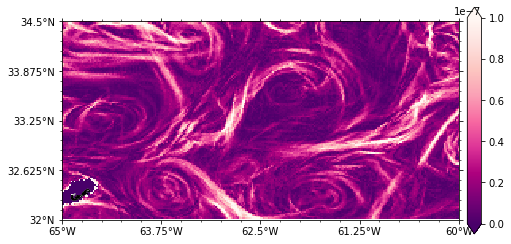

In [314]:
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp_large, fig_size_fac=2, projection=ccrs_proj, axlab_kw=None)
ii=-1
lon_reg1 = data_M2_mean.lon
lat_reg1 = data_M2_mean.lat
lon_reg = [-65, -60]
lat_reg = [32, 34.5]

ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 0, 1e-7
pyic.shade(lon_reg1, lat_reg1, data_M2_mean.isel(depthi=17), ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim, cmap='RdPu_r')
#ax.set_title('mean', fontsize=30)

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) # , xlim=lon_region_large, ylim=lat_region_large

In [278]:
data_M2_mean.lon[-313]

<xarray.DataArray 'lon' ()>
array(-61.26)
Coordinates:
    lon      float64 -61.26

(250.0, 0.0)

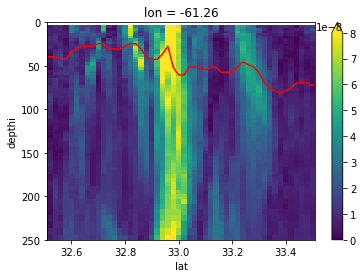

In [303]:
m2=data_M2_mean.sel(lat=slice(32.5,33.5)).sel(lon=-61.25, method='nearest')
m2.plot(vmin=0, vmax=8e-8, )
plt.plot(data_M2_mean.lat, mld[:,-313], 'r')
plt.ylim(250,0)

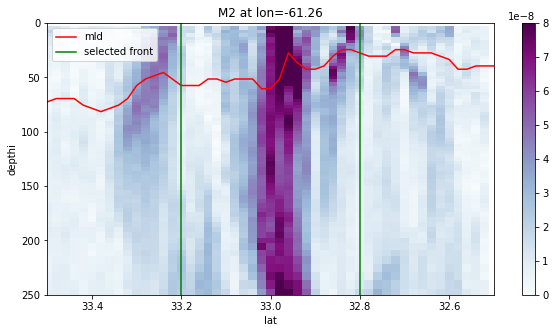

In [414]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
cf = ax.pcolormesh(m2.lat, m2.depthi, m2, vmin=0, vmax=8e-8,  cmap='BuPu')
plt.plot(data_M2_mean.lat, mld[:,-313],'r', label='mld')
plt.axvline(x=33.2, color='g', linestyle='-', label='selected front')
plt.axvline(x=32.8, color='g', linestyle='-')
plt.gca().invert_yaxis()
cb = fig.colorbar(cf, ax=ax)
plt.xlim(33.5,32.5)
plt.ylim(250,0)
plt.title(f'M2 at lon={m2.lon.data:.2f}')
plt.xlabel('lat')
plt.ylabel('depthi')
plt.legend()

plt.savefig(f'../images/eval_ri/m2_front.png', dpi=150, format='png', bbox_inches='tight')



### selection of front
lat = 33.2, 32,8
depth is mld

In [369]:
0.02*111 * np.sin(40*np.pi/180.)

1.4269884935041173

In [318]:
M2_mld.lat

<xarray.DataArray 'lat' (lat: 500)>
array([32.02, 32.04, 32.06, ..., 41.96, 41.98, 42.  ])
Coordinates:
  * lat      (lat) float64 32.02 32.04 32.06 32.08 ... 41.94 41.96 41.98 42.0

In [320]:
m2_fslect = M2_mld.sel(lon=-61.25, method='nearest').sel( lat=slice(32.8,33.2)).mean(dim='depthi', skipna=True)
m2_fslect

<xarray.DataArray (lat: 20)>
array([6.40448334e-08, 3.98417690e-08, 2.57727706e-08, 1.68310219e-08,
       3.45296804e-08, 5.11896445e-08, 5.44158638e-08, 1.13045047e-07,
       1.10104004e-07, 6.98642566e-08, 4.06058014e-08, 2.00897592e-08,
       2.98020968e-08, 2.63765720e-08, 2.74184728e-08, 1.46509729e-08,
       8.22182589e-09, 3.16375992e-09, 7.34195904e-09, 1.83883238e-08],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 32.82 32.84 32.86 32.88 ... 33.14 33.16 33.18 33.2
    lon      float64 -61.26

In [418]:
wb_fselect = wb_mld.sel(lon=-61.25, method='nearest').sel( lat=slice(32.8,33.2))#.mean(dim='depthi', skipna=True)
ri_fselect = ri_mld.sel(lon=-61.25, method='nearest').sel( lat=slice(32.8,33.2))#.mean(dim='depthi', skipna=True)
mldx_fselect = mldx.sel(lon=-61.25, method='nearest').sel( lat=slice(32.8,33.2))

In [419]:

alpha = m2_fslect / np.power(f,2)
lhs = wb_fselect / np.power(mldx_fselect,2) / np.power(f,3) / np.power(alpha,2)
lhs_without_alpha = wb_fselect / np.power(mldx_fselect,2) / np.power(f,3)
rhs = 1 / np.sqrt(1 + ri_fselect) #* np.power(alpha,2) #* mu * np.power(alpha,2)

In [420]:
logx, logy = calc_log10(np.reshape(ri_fselect.data, ri_fselect.size), np.reshape(lhs.data, ri_fselect.size))

LinregressResult(slope=0.6276191179298396, intercept=0.04925017275340113, rvalue=0.7021792690929782, pvalue=1.2009740354245225e-43, stderr=0.0378298878760309, intercept_stderr=0.03387303771441024)

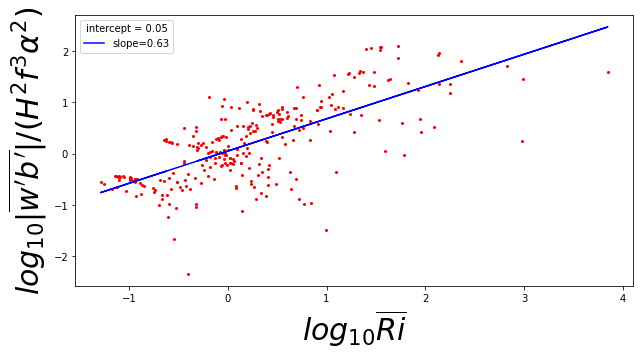

In [421]:

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=2)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

# x1 = np.linspace(-1,6,100)
# y1 = -0.5*x1 + 1
# plt.plot(x1,y1, label='slope ALS, NLS: -0.5', color='black')
#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{Ri}$', fontsize=30)
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3 \alpha^2) $', fontsize=30)

plt.legend(title=f'intercept = {res.intercept:.1}')

#plt.savefig(f'../images/eval_ri/wb_ri_vert_mean_scaled_alpha_{calcname}.png', dpi=150, format='png', bbox_inches='tight')
plt.savefig(f'../images/eval_ri/corellation_front.png', dpi=150, format='png', bbox_inches='tight')

res